# Mesh 3-pt calculations

This package includes mesh-based bispectrum estimation.

## Bispectrum from mesh

In [1]:
# Let's create some mock mesh!
import jax
from jax import numpy as jnp
from jaxpower import MeshAttrs, Spectrum2Poles, generate_anisotropic_gaussian_mesh
meshsize = 64

def get_theory(kmax=0.3, dk=0.001):
    # Return theory power spectrum
    from cosmoprimo.fiducial import DESI
    cosmo = DESI(engine='eisenstein_hu')
    z = 1.
    pk1d = cosmo.get_fourier().pk_interpolator().to_1d(z=z)
    ellsin = (0, 2, 4)
    edgesin = jnp.arange(0., kmax, dk)
    edgesin = jnp.column_stack([edgesin[:-1], edgesin[1:]])
    kin = (edgesin[..., 0] + edgesin[..., 1]) / 2.
    f, b = cosmo.growth_rate(z), 1.5
    beta = f / b
    shotnoise = (1e-3)**(-1)
    pk = pk1d(kin)
    poles = jnp.array([(1. + 2. / 3. * beta + 1. / 5. * beta ** 2) * pk + shotnoise,
                        0.99 * (4. / 3. * beta + 4. / 7. * beta ** 2) * pk,
                        8. / 35 * beta ** 2 * pk])
    return Spectrum2Poles(k=[kin] * len(ellsin), edges=[edgesin] * len(ellsin), num=list(poles), num_shotnoise=shotnoise, ells=ellsin)


mattrs = MeshAttrs(boxsize=1000., meshsize=meshsize)
poles = get_theory(4 * mattrs.knyq.max())
mesh = generate_anisotropic_gaussian_mesh(mattrs, poles, los='z', seed=68, order=1, unitary_amplitude=True)
print(mesh)

/local/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


RealMeshField(attrs=MeshAttrs(meshsize=staticarray([64, 64, 64], dtype=int32), boxsize=Array([1000., 1000., 1000.], dtype=float32), boxcenter=Array([0., 0., 0.], dtype=float32), dtype=dtype('float32'), fft_engine='jaxdecomp'))


In [2]:
# Now compute bispectrum
from jaxpower import compute_mesh3_spectrum, BinMesh3Spectrum

# This can be instantiated once for many bispectrum calculations as long as they share the same MeshAttrs
bin = BinMesh3Spectrum(mattrs, edges={'step': 0.02}, basis='scoccimarro', ells=[0, 2], buffer_size=10)

# One can jit the bispectrum calculation
compute = jax.jit(compute_mesh3_spectrum, static_argnames=['los'])

bk = compute(mesh, bin=bin, los='z')

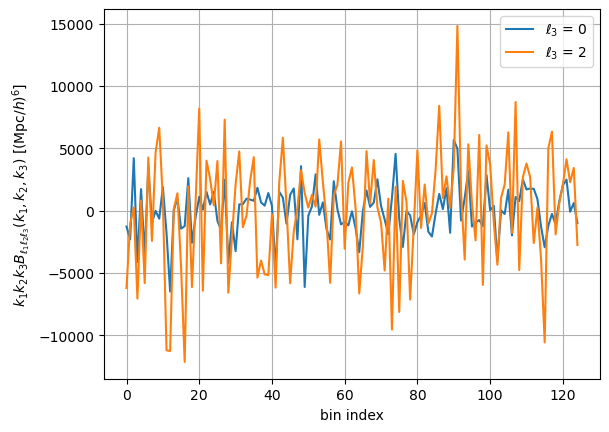

In [3]:
bk.plot(show=True);

In [4]:
# Interlude: the measurement
bk2 = bk.slice(slice(0, None, 2))  # rebin by a factor 2
bk2 = bk2.select(xlim=(0.05, 0.2))  # select 0.05 <= k [h/Mpc] < 0.2
bk2 = bk2.select(projs=[0, 2], select_projs=True)  # restrict to ell = 0, 2
bk2.view(projs=0)  # to view as an array
bk2.k(projs=0)  # k for ell = 0  (also: bk2.x(projs=0))
bk2.nmodes(projs=0)  # number of modes  (also: bk2.weights(projs=0))
bk2.edges(projs=0);  # edges

## Bispectrum from particles (FKP)

In [5]:
# Let's create some mock particles!
from jaxpower import generate_uniform_particles

mattrs = MeshAttrs(boxsize=1000., meshsize=meshsize, boxcenter=700.)
poles = get_theory(4 * mattrs.knyq.max())
# With local line-of-sight
mmesh = generate_anisotropic_gaussian_mesh(mattrs, poles, los='local', seed=68, order=1, unitary_amplitude=True)

# Generate particles in smaller volume
pattrs = mattrs.clone(boxsize=500.)
size = int(1e6)
data = generate_uniform_particles(pattrs, size, seed=42)
# Set weights = 1 + delta
data = data.clone(weights=1. + mmesh.read(data.positions, resampler='cic', compensate=True))

# Now randoms
randoms = generate_uniform_particles(pattrs, 2 * size, seed=43)

/local/home/adematti/Bureau/DESI/NERSC/cosmodesi/cosmoprimo/cosmoprimo/eisenstein_hu.py:25: UserWarning: EisensteinHuEngine cannot cope with massive neutrinos
  warnings.warn('{} cannot cope with massive neutrinos'.format(self.__class__.__name__))


In [6]:
from jaxpower import FKPField, compute_fkp3_spectrum_normalization, compute_fkp3_spectrum_shotnoise, get_mesh_attrs

# Define MeshAttrs from positions
mattrs = get_mesh_attrs(data.positions, randoms.positions, boxpad=2., meshsize=meshsize)

fkp = FKPField(data, randoms, attrs=mattrs)
norm, num_shotnoise = compute_fkp3_spectrum_normalization(fkp), compute_fkp3_spectrum_shotnoise(fkp, bin=bin, resampler='tsc', interlacing=3, compensate=True)
# Paint particles to mesh
mesh = fkp.paint(resampler='tsc', interlacing=3, compensate=True, out='real')
del fkp
# Tip: can be done once for many P(k) evaluation
bin = BinMesh3Spectrum(mattrs, edges={'step': 0.02}, basis='scoccimarro', ells=[0, 2], buffer_size=10)
# Then compute power spectrum
# One can jit the function
compute = jax.jit(compute_mesh3_spectrum, static_argnames=['los'])
bk = compute(mesh, bin=bin, los='local')
# Add the normalization and shot noise information
bk = bk.clone(norm=norm, num_shotnoise=num_shotnoise)

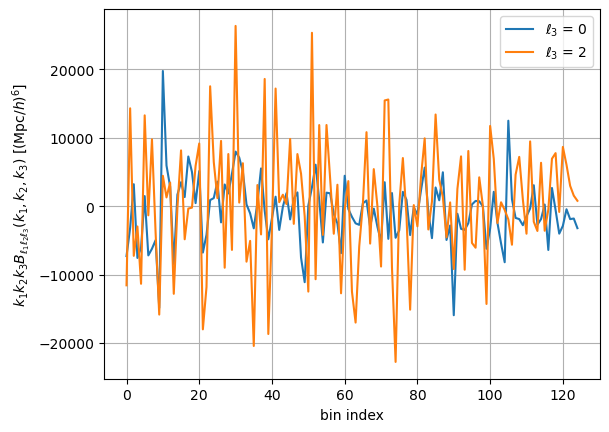

In [7]:
bk.plot(show=True);